In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer, make_classification
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut

from sampler import sample_from_logreg

from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics.pairwise import polynomial_kernel
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

from cv_svm import SVM_smooth
from kernel_svm import SVM_smooth_kernel

import matplotlib
#matplotlib.use("pgf")
#matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
#    'text.usetex': True,
#    'pgf.rcfonts': False,
#})

In [2]:
#X, y = load_breast_cancer(return_X_y=True)
#X, y = make_classification(n_samples=250, n_features=50)
X, _, y = sample_from_logreg(n=100, p=10, seed=120)
n = X.shape[0]
p = X.shape[1]
y[np.where(y == 0)] = -1

In [3]:
X_scaled = StandardScaler().fit_transform(X)
#X_scaled = X
print(X_scaled.shape)

(100, 10)


In [4]:
clf = SVC(kernel='rbf')
clf.fit(X_scaled, y)
coef = clf.dual_coef_

In [5]:
y_pred = clf.predict(X_scaled)
accuracy_score(y, y_pred)

0.93

In [6]:
sigma = 1e-10
lbd = 1e-10
#length_scale = 1000
length_scale = 2.75
degree = 6

In [7]:
# calculate maximum bound
from sklearn.metrics import pairwise_distances
m_max = np.min(pairwise_distances(X))**2
print(m_max)
m_max = 0
gram = RBF(length_scale)(X, X)
gram_inv = np.linalg.inv(gram)

C = np.linalg.norm(gram.T @ gram)/(n-1)
print(np.linalg.norm(gram_inv) * np.linalg.norm(gram))

# what lambda do we have to pick?
b = np.linalg.norm(gram_inv) * np.linalg.norm(gram) + 10
big_term = 1/(2 * np.sqrt(1 + (m_max/sigma)**2)**3)

bound = np.linalg.norm(gram_inv) * (lbd * np.linalg.norm(gram) + C * big_term)/lbd
print(f"Bound is {bound}")

lbd_pick = (np.linalg.norm(gram_inv) * C * big_term)/(b - np.linalg.norm(gram_inv) * np.linalg.norm(gram))

lbd_pick

0.0
5467.512317152088
Bound is 8437602838140.995


84.37602832673483

In [8]:
clf = SVM_smooth_kernel(sigma=sigma, lbd=lbd, kernel=RBF(length_scale))
clf.fit(X_scaled, y, n_iter=5, eta=0.5/n, approx_cv=True,
        cv=True, log_iacv=True, save_err_approx=True, save_err_cv=True, save_cond_num=True)

y_pred = clf.predict(X_scaled)
accuracy_score(y, y_pred)

| IACV: 0.00013233 | baseline: 0.00024208
| IACV: 0.00026465 | baseline: 0.00048417
| IACV: 0.00039698 | baseline: 0.00072625
| IACV: 0.00052930 | baseline: 0.00096834
| IACV: 0.00066163 | baseline: 0.00121042


0.53

In [9]:
coef = clf.u_/np.linalg.norm(clf.u_)
iacv_coef = normalize(clf.approx_cv_obj.iterates, axis=1)
true_coef = normalize(clf.true_cv_obj.iterates, axis=1)
print(np.mean(np.linalg.norm(iacv_coef - true_coef, 2, axis=1)))
print(np.mean(np.linalg.norm(coef - true_coef, 2, axis=1)))

0.0690371719429584
0.12166316126053457


In [10]:
print(np.std(clf.approx_cv_obj.iterates))
print(np.std(clf.true_cv_obj.iterates))

0.0008391567
0.0008293586891377147


In [11]:
print(np.mean(clf.approx_cv_obj.iterates, axis=0))
print(np.mean(clf.true_cv_obj.iterates, axis=0))

[-1.18137081e-03  7.57501693e-04 -9.40400467e-04  1.00269460e-03
  1.77735090e-03 -1.29076303e-03  7.67643505e-04  1.17053256e-04
 -2.97472667e-04 -1.93419924e-04  1.01268094e-03  1.26907253e-03
  1.82771857e-03 -2.83506262e-04 -2.94457132e-04 -2.34181352e-04
  1.86695298e-03  1.26360543e-03  1.80478953e-03  1.26945658e-03
  4.69420687e-04 -3.58005578e-04 -5.46306197e-04  1.35365734e-03
  9.56612639e-04  3.58450547e-04  1.18578179e-03 -4.09609813e-04
 -1.49976520e-03 -2.47776508e-04  8.07783275e-04  1.08645007e-03
  1.31395273e-03  6.33069838e-04  2.18018249e-04 -4.31117864e-04
  1.11550573e-04 -7.36667367e-04  1.29542677e-04 -1.03428094e-04
  1.58851710e-03  1.35168212e-03  3.98706557e-04  9.15393815e-04
  1.57386274e-03  1.75735564e-03 -4.76930989e-04 -9.46287619e-05
 -3.76415381e-04  4.64740006e-04 -5.82759210e-04 -3.65637272e-04
  4.04971470e-05  2.96569022e-04  1.27145299e-03  6.56981138e-04
  1.16231455e-03  1.44993269e-03 -1.13757956e-03  1.90131104e-04
 -3.64736159e-04 -9.40174

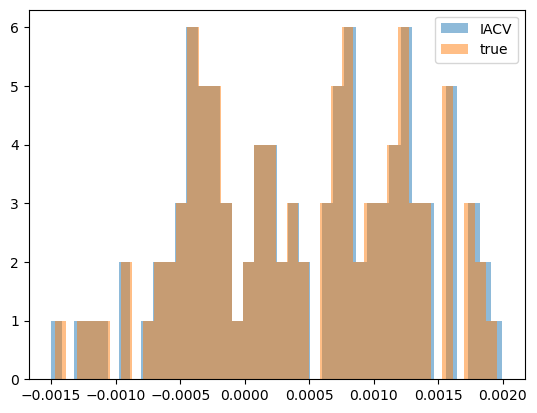

In [12]:
plt.hist(np.mean(clf.approx_cv_obj.iterates, axis=0), alpha=0.5, bins=40, label="IACV")
plt.hist(np.mean(clf.true_cv_obj.iterates, axis=0), alpha=0.5, bins=40, label="true")
plt.legend()

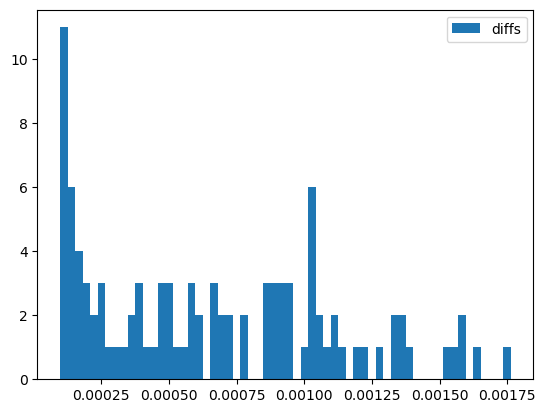

In [13]:
plt.hist(np.linalg.norm(clf.approx_cv_obj.iterates - clf.true_cv_obj.iterates, axis=1), bins=60, label="diffs")
plt.legend()

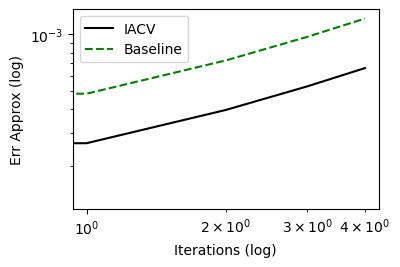

In [14]:
fig, ax = plt.subplots()
ax.plot(clf.err_approx_["IACV"], label="IACV", c='black')
#ax.plot(clf.err_approx_["NS"], label="NS", c='red', linestyle="--")
ax.plot(clf.err_approx_["baseline"], label="Baseline", c='green', linestyle="--")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Iterations (log)")
ax.set_ylabel("Err Approx (log)")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
#plt.savefig('kernel_svm_convergence_err_approx_cont.pgf', bbox_inches='tight', pad_inches=0)

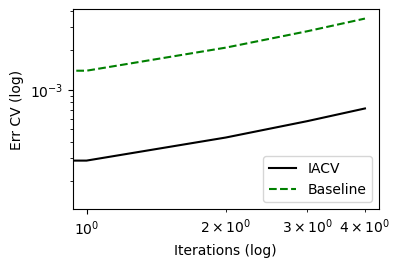

In [15]:
fig, ax = plt.subplots()
ax.plot(clf.err_cv_["IACV"], label="IACV", c='black')
ax.plot(clf.err_cv_["baseline"], label="Baseline", c='green', linestyle="--")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Iterations (log)")
ax.set_ylabel("Err CV (log)")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
#plt.savefig('kernel_svm_convergence_err_cv_cont.pgf', bbox_inches='tight', pad_inches=0)

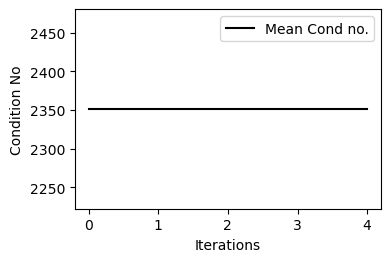

<Figure size 640x480 with 0 Axes>

In [16]:
fig, ax = plt.subplots()
cond_nums = np.asarray(clf.approx_cv_obj.cond_nums)
ax.plot(np.mean(cond_nums, axis=1), label="Mean Cond no.", c='black')
ax.set_xlabel("Iterations")
ax.set_ylabel("Condition No")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
plt.savefig('kernel_svm_convergence_cond_no_fail.pgf', bbox_inches='tight', pad_inches=0)

In [17]:
# test different sigma values
import time
#sigmas = [2e-30, 2e-25, 2e-15, 2e-10, 2e-5, 2e-1]
#sigmas = [2e-15, 2e-10, 2e-5, 2e-3, 2e-1, 5e-1, 7e-1, 8e-1, 1, 1.25, 1.5, 2]
sigmas = [2e-15, 2e-12, 2e-10, 2e-8, 2e-5, 2e-3, 2e-1, 5e-1, 8e-1, 1]
last_err_approx = np.empty((len(sigmas), 2))
last_err_cv = np.empty((len(sigmas), 2))
cond_nums = np.empty(len(sigmas))

start = time.time()
for i, s in enumerate(sigmas):
    if s == 0:
        continue
    #clf = SVM_smooth(sigma=s, lbd=1)
    clf = SVM_smooth_kernel(sigma=s, lbd=1, kernel=RBF(2.75))
    print(f"running experiment for sigma = {s}")
    clf.fit(X_scaled, y, n_iter=200, eta=0.5/n, approx_cv=True, cv=True, log_iacv=False, log_iter=False,
           save_err_cv=True, save_err_approx=True, save_cond_num=True)
    y_pred = clf.predict(X_scaled)
    score = accuracy_score(y, y_pred)
    print(f"\tsigma {s} | score {score}")
    #print(clf.weights_)
    print(f"\tErr_Approx IACV: {clf.err_approx_['IACV'][-1]} | baseline: {clf.err_approx_['baseline'][-1]}" )
    print(f"\tErr_CV     IACV: {clf.err_cv_['IACV'][-1]} | baseline: {clf.err_cv_['baseline'][-1]}" )
    last_err_approx[i] = [clf.err_approx_["IACV"][-1], clf.err_approx_["baseline"][-1]]
    last_err_cv[i] = [clf.err_cv_["IACV"][-1], clf.err_cv_["baseline"][-1]]
    cond_nums[i] = np.mean(clf.approx_cv_obj.cond_nums)

end = time.time()
print(end - start)

running experiment for sigma = 2e-15
	sigma 2e-15 | score 0.85
	Err_Approx IACV: 0.004663216415792704 | baseline: 0.0075616181026518505
	Err_CV     IACV: 0.0016289913328364491 | baseline: 0.009389985352754593
running experiment for sigma = 2e-12
	sigma 2e-12 | score 0.85
	Err_Approx IACV: 0.004663216415792704 | baseline: 0.0075616181026518505
	Err_CV     IACV: 0.0016289890045300126 | baseline: 0.009389986284077168
running experiment for sigma = 2e-10
	sigma 2e-10 | score 0.85
	Err_Approx IACV: 0.004663216415792704 | baseline: 0.0075616181026518505
	Err_CV     IACV: 0.0016289878403767943 | baseline: 0.009389985352754593
running experiment for sigma = 2e-08
	sigma 2e-08 | score 0.85
	Err_Approx IACV: 0.004663216415792704 | baseline: 0.0075616181026518505
	Err_CV     IACV: 0.0016289895866066217 | baseline: 0.009389987215399742
running experiment for sigma = 2e-05
	sigma 2e-05 | score 0.85
	Err_Approx IACV: 0.004663215950131416 | baseline: 0.007561618101830766
	Err_CV     IACV: 0.001628984

In [18]:
last_err_cv = np.asarray(last_err_cv)
last_err_approx = np.asarray(last_err_approx)

last_err_cv = np.nan_to_num(last_err_cv, nan=1e2)
last_err_approx = np.nan_to_num(last_err_approx, nan=1e2)

last_err_cv = np.clip(last_err_cv, 0, 1e2)
last_err_approx = np.clip(last_err_approx, 0, 1e2)

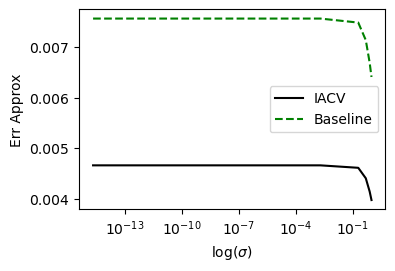

<Figure size 640x480 with 0 Axes>

In [19]:
fig, ax = plt.subplots()
ax.plot(sigmas, last_err_approx[:, 0], label="IACV", c='black')
ax.plot(sigmas, last_err_approx[:, 1], label="Baseline", c='green', linestyle="--")
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel("$\log(\sigma)$")
ax.set_ylabel("Err Approx")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
plt.savefig('kernel_svmtest_sigma_err_approx_mod.pgf', bbox_inches='tight', pad_inches=0)

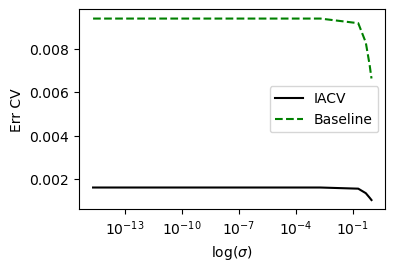

<Figure size 640x480 with 0 Axes>

In [20]:
fig, ax = plt.subplots()
ax.plot(sigmas, last_err_cv[:, 0], label="IACV", c='black')
ax.plot(sigmas, last_err_cv[:, 1], label="Baseline", c='green', linestyle="--")
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel("$\log(\sigma)$")
ax.set_ylabel("Err CV")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
plt.savefig('kernel_svmtest_sigma_err_cv_mod.pgf', bbox_inches='tight', pad_inches=0)

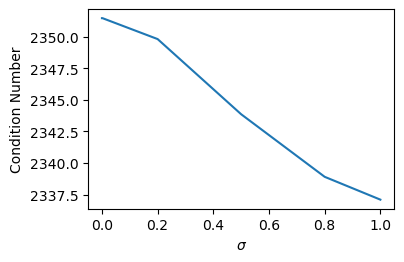

In [23]:
fig, ax = plt.subplots()
ax.plot(sigmas, cond_nums)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel("$\sigma$")
ax.set_ylabel("Condition Number")
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
#plt.savefig('svmtest_sigma_err_cv_mod.pgf', bbox_inches='tight', pad_inches=0)

In [23]:
# test different lambda values
import time
lambdas = np.linspace(0, 2.5, 12)
print(lambdas)
last_err_approx = []
last_err_cv = []
condition_nos = []
iacv_iterates = []
true_iterates = []

start = time.time()
for l in lambdas:
    print(f"running experiment for lambda = {l}")
    clf = SVM_smooth_kernel(sigma=0.25, lbd=l, kernel=RBF(2.75))
    clf.fit(X_scaled, y, n_iter=400, eta=0.5/n, approx_cv=True, cv=True,
            save_err_approx=True, save_err_cv=True, log_iacv=False, log_iter=False, save_cond_num=True)
    y_pred = clf.predict(X_scaled)
    score = accuracy_score(y, y_pred)
    
    condition_nos.append(clf.approx_cv_obj.cond_nums)
    iacv_iterates.append(clf.approx_cv_obj.iterates)
    true_iterates.append(clf.true_cv_obj.iterates)

    #coef = clf.weights_/np.linalg.norm(clf.weights_)

    #print(clf.weights_)
    #print(f"\tlambda {l} | score {score} | grad {np.linalg.norm(clf.nabla_fgd_(clf.weights_, X_scaled, y, clf.sigma_, clf.lbd_))} | sklearn diff {np.mean(np.abs(coef- sk_coef))}")
    print(f"\tlambda {l} | score {score}")
    print(f"\tIACV: {clf.err_approx_['IACV'][-1]} | baseline: {clf.err_approx_['baseline'][-1]}" )
    last_err_approx.append([clf.err_approx_["IACV"][-1], clf.err_approx_["baseline"][-1]])
    last_err_cv.append([clf.err_cv_["IACV"][-1], clf.err_cv_["baseline"][-1]])

end = time.time()
print(end - start)

[0.         0.22727273 0.45454545 0.68181818 0.90909091 1.13636364
 1.36363636 1.59090909 1.81818182 2.04545455 2.27272727 2.5       ]
running experiment for lambda = 0.0
	lambda 0.0 | score 0.6
	IACV: 611623168.0 | baseline: 0.06267089192042757
running experiment for lambda = 0.22727272727272727
	lambda 0.22727272727272727 | score 0.83
	IACV: 0.0190909281373024 | baseline: 0.027288153160906065
running experiment for lambda = 0.45454545454545453
	lambda 0.45454545454545453 | score 0.85
	IACV: 0.010150769725441933 | baseline: 0.016105075639979177
running experiment for lambda = 0.6818181818181818
	lambda 0.6818181818181818 | score 0.85
	IACV: 0.006454028654843569 | baseline: 0.01133675118567281
running experiment for lambda = 0.9090909090909091
	lambda 0.9090909090909091 | score 0.85
	IACV: 0.0045706843957304955 | baseline: 0.008784008695026501
running experiment for lambda = 1.1363636363636362
	lambda 1.1363636363636362 | score 0.85
	IACV: 0.0034680720418691635 | baseline: 0.0071990288

In [24]:
last_err_approx = np.asarray(last_err_approx)
last_err_cv = np.asarray(last_err_cv)
condition_nos = np.asarray(condition_nos)
iacv_iterates = np.asarray(iacv_iterates)
true_iterates = np.asarray(true_iterates)

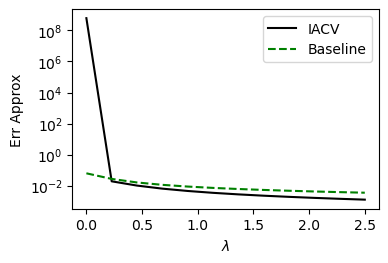

In [35]:
fig, ax = plt.subplots()
ax.plot(lambdas, last_err_approx[:, 0], label="IACV", c='black')
ax.plot(lambdas, last_err_approx[:, 1], label="Baseline", c='green', linestyle="--")
ax.set_yscale('log')
ax.set_xlabel("$\lambda$")
ax.set_ylabel("Err Approx")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
#plt.savefig('kernel_svmtest_lambda_err_approx_mod.pgf', bbox_inches='tight', pad_inches=0)

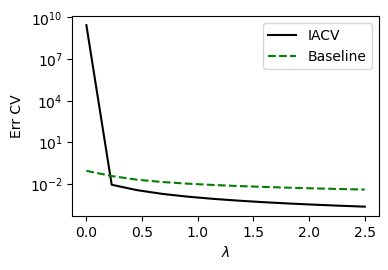

In [36]:
fig, ax = plt.subplots()
ax.plot(lambdas, last_err_cv[:, 0], label="IACV", c='black')
ax.plot(lambdas, last_err_cv[:, 1], label="Baseline", c='green', linestyle="--")
ax.set_yscale('log')
ax.set_xlabel("$\lambda$")
ax.set_ylabel("Err CV")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
#plt.savefig('kernel_svmtest_lambda_err_cv_mod.pgf', bbox_inches='tight', pad_inches=0)

In [27]:
mean_cond = np.asarray(condition_nos)
mean_cond = np.mean(np.mean(condition_nos, axis=1), axis=1)

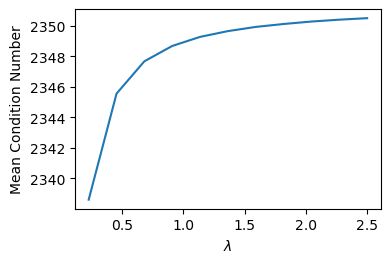

<Figure size 640x480 with 0 Axes>

In [37]:
fig, ax = plt.subplots()
ax.plot(lambdas[1:], mean_cond[1:])
ax.set_xlabel("$\lambda$")
ax.set_ylabel("Mean Condition Number")
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
plt.savefig('svmtest_lambda_cond_no_mod.pgf', bbox_inches='tight', pad_inches=0)

## fig, ax = plt.subplots()
start = 0
ax.plot(lambdas[start:], iacv_means[start:], label="IACV")
ax.plot(lambdas[start:], true_means[start:], label="true", linestyle="--")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("Mean of CV Iterates")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
#plt.savefig('svmtest_lambda_coef_mod.pgf', bbox_inches='tight', pad_inches=0)